In [53]:
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn


source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation
from visualization.epochs import EpochAnimation

from model import Model


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [54]:
## Load settings
settings = "rich"

(nonlinearity, gain, lr, P, L, n_epochs) = (
    pd.read_csv("model settings/rnn.txt", sep=" ", header=0).loc[settings].to_numpy()
)
P, L, n_epochs = int(P), int(L), int(n_epochs)

In [55]:
## Generate data
symbols = [0, 1]
encoding = OneHot(symbols)
xor_problem = lambda seq: np.sum(seq) % 2
# par_3_problem = lambda seq: int(np.sum(seq) % 3 == 2)

problem = xor_problem

train_datasets = [
    seq_data(device, problem, encoding, seq_len=1),
    seq_data(device, problem, encoding, seq_len=2),
    seq_data(device, problem, encoding, seq_len=3),
    seq_data(device, problem, encoding, seq_len=4),
    seq_data(device, problem, encoding, seq_len=5),
    # seq_data(device, problem, encoding, seq_len=6),
]

val_dataset = [seq_data(device, problem, encoding, n_datapoints=50, seq_len=10)]
tracked_datasets = val_dataset + train_datasets

In [56]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
)

In [57]:
## Setup compiler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model,
        lambda inputs: model(inputs)[1][-1],
        tracked_datasets,
        initial=lambda: initial_hidden,
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], tracked_datasets
    ),
}

In [58]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=1000
)

Training:  70%|███████   | 350/500 [00:23<00:11, 13.02steps/s, train_loss=0.00174, val_loss=0.08906]

Computing automata: 100%|██████████| 500/500 [00:03<00:00, 136.38it/s]
/home/loek/projects/rnn_structure/example/../source/utils/dataframes.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  label.loc[index] = index
/home/loek/projects/rnn_structure/example/../source/utils/dataframes.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  label.loc[index] = index


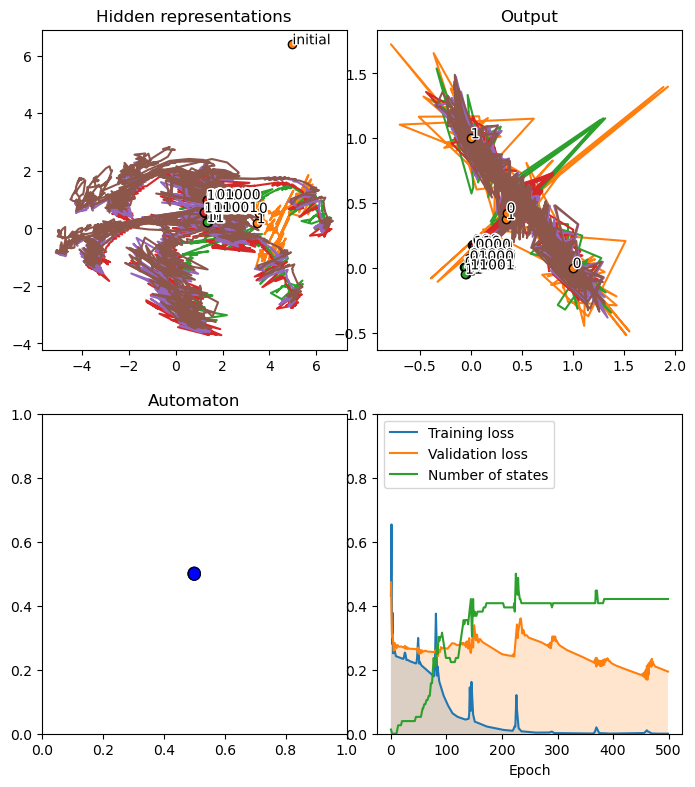

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

In [ ]:
## Visualize automaton dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset != 0) and (Dataset <= 5)"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))

automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=0.2 * std
)
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_states = np.array([len(automaton.states) for automaton in automaton_history])


animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(data_hid, transform="PCA"),
        "Output": ActivationsAnimation(
            data_output, transform="none", fixed_points=encoding.encoding
        ),
        "Automaton": AutomatonAnimation(automaton_history),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                "Number of states": n_states,
            },
            y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

# animation.to_gif("animation")

100%|██████████| 100/100 [00:00<00:00, 160.91it/s]


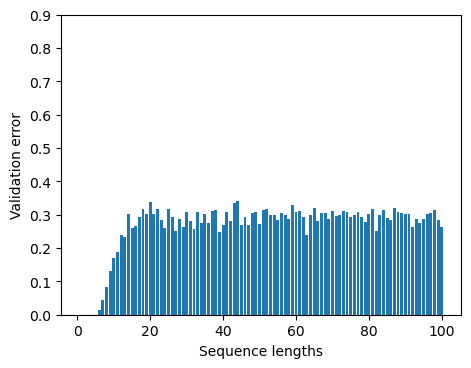

In [ ]:
## Check for generalization
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=100, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(1, N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()